<a href="https://colab.research.google.com/github/Kryptera-K/KKR-BearDe-AO-BB-Strategy/blob/main/KKR_D1_%5B'BearP_Falling'_'BB_Open_Above_Lower'%5D_%5B'AO_Rising'_'Demarker_Is_Lower_Than_Level'%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Parameters
# -------------------------
symbol = "KKR"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

# -------------------------
# Download Data
# -------------------------
df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)

# -------------------------
# Bears Power
# -------------------------
ema_period = 13
df['EMA'] = df['Close'].ewm(span=ema_period, adjust=False).mean()
df['Bears_Power'] = df['Low'] - df['EMA']
df['BearP_Falling'] = df['Bears_Power'] < df['Bears_Power'].shift(1)

# -------------------------
# Bollinger Bands
# -------------------------
bb_period = 20
bb_std = 2
df['BB_MA'] = df['Close'].rolling(window=bb_period).mean()
df['BB_Lower'] = df['BB_MA'] - bb_std * df['Close'].rolling(window=bb_period).std()
df['BB_Open_Above_Lower'] = df['Open'] > df['BB_Lower']

# -------------------------
# Awesome Oscillator
# -------------------------
short_period = 5
long_period = 34
df['MedianPrice'] = (df['High'] + df['Low']) / 2
df['SMA_short'] = df['MedianPrice'].rolling(window=short_period).mean()
df['SMA_long'] = df['MedianPrice'].rolling(window=long_period).mean()
df['AO'] = df['SMA_short'] - df['SMA_long']
ao_shift = 5
df['AO_Rising'] = df['AO'] > df['AO'].shift(ao_shift)

# -------------------------
# DeMarker
# -------------------------
dem_period = 14
df['DeMax'] = np.where(df['High'] > df['High'].shift(1), df['High'] - df['High'].shift(1), 0)
df['DeMin'] = np.where(df['Low'] < df['Low'].shift(1), df['Low'].shift(1) - df['Low'], 0)
dem_max = df['DeMax'].rolling(window=dem_period).sum()
dem_min = df['DeMin'].rolling(window=dem_period).sum()
df['DeMarker'] = dem_max / (dem_max + dem_min)
df['Demarker_Is_Lower_Than_Level'] = df['DeMarker'] < 0.5

# -------------------------
# Entry / Exit Signals
# -------------------------
entry_conditions = ['BearP_Falling', 'BB_Open_Above_Lower']
exit_conditions  = ['AO_Rising', 'Demarker_Is_Lower_Than_Level']

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------
entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)

print(pf.stats())
pf.plot().show()


/tmp/ipython-input-3644035697.py:17: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


Start                                2010-07-15 00:00:00
End                                  2025-09-26 00:00:00
Period                                3825 days 00:00:00
Start Value                                     100000.0
End Value                                 3111733.213879
Total Return [%]                             3011.733214
Benchmark Return [%]                         2162.675222
Max Gross Exposure [%]                             100.0
Total Fees Paid                            136310.228673
Max Drawdown [%]                                53.82055
Max Drawdown Duration                  505 days 00:00:00
Total Trades                                          94
Total Closed Trades                                   93
Total Open Trades                                      1
Open Trade PnL                              547866.11991
Win Rate [%]                                   52.688172
Best Trade [%]                                 88.712703
Worst Trade [%]                

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2010-07-15 00:00:00
End                           2025-09-26 00:00:00
Period                         3825 days 00:00:00
Start Value                              100000.0
End Value                          2262675.221672
Total Return [%]                      2162.675222
Benchmark Return [%]                  2162.675222
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        52.894664
Max Drawdown Duration           612 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                     2162675.221672
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-4086488281.py:17: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


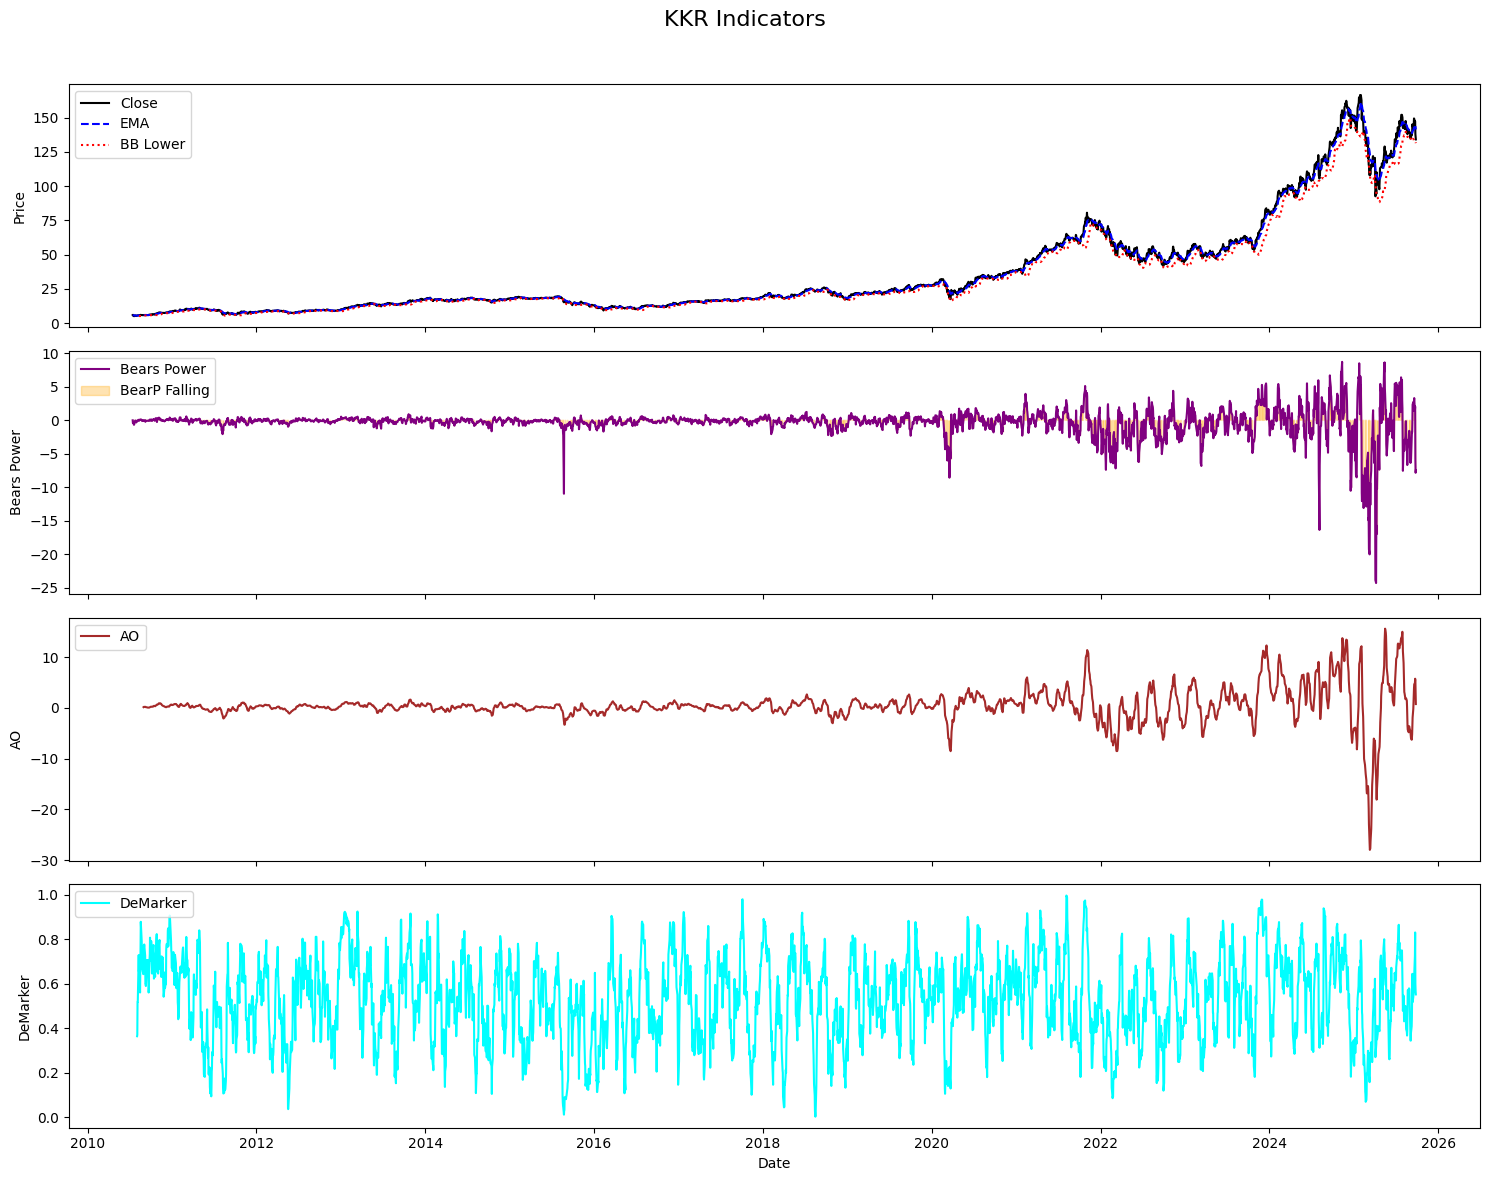

In [ ]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np

# -------------------------
# Parameters
# -------------------------
symbol = "KKR"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

# -------------------------
# Download Data
# -------------------------
df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)

# -------------------------
# Bears Power
# -------------------------
ema_period = 13
df['EMA'] = df['Close'].ewm(span=ema_period, adjust=False).mean()
df['Bears_Power'] = df['Low'] - df['EMA']
df['BearP_Falling'] = df['Bears_Power'] < df['Bears_Power'].shift(1)

# -------------------------
# Bollinger Bands
# -------------------------
bb_period = 20
bb_std = 2
df['BB_MA'] = df['Close'].rolling(window=bb_period).mean()
df['BB_Lower'] = df['BB_MA'] - bb_std * df['Close'].rolling(window=bb_period).std()
df['BB_Open_Above_Lower'] = df['Open'] > df['BB_Lower']

# -------------------------
# Awesome Oscillator
# -------------------------
short_period = 5
long_period = 34
df['MedianPrice'] = (df['High'] + df['Low']) / 2
df['SMA_short'] = df['MedianPrice'].rolling(window=short_period).mean()
df['SMA_long'] = df['MedianPrice'].rolling(window=long_period).mean()
df['AO'] = df['SMA_short'] - df['SMA_long']
ao_shift = 5
df['AO_Rising'] = df['AO'] > df['AO'].shift(ao_shift)

# -------------------------
# DeMarker
# -------------------------
dem_period = 14
df['DeMax'] = np.where(df['High'] > df['High'].shift(1), df['High'] - df['High'].shift(1), 0)
df['DeMin'] = np.where(df['Low'] < df['Low'].shift(1), df['Low'].shift(1) - df['Low'], 0)
dem_max = df['DeMax'].rolling(window=dem_period).sum()
dem_min = df['DeMin'].rolling(window=dem_period).sum()
df['DeMarker'] = dem_max / (dem_max + dem_min)
df['Demarker_Is_Lower_Than_Level'] = df['DeMarker'] < 0.5

# -------------------------
# Plotting
# -------------------------
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
fig.suptitle(f'{symbol} Indicators', fontsize=16)

# Price + EMA + Bollinger Band
axes[0].plot(df['Close'], label='Close', color='black')
axes[0].plot(df['EMA'], label='EMA', color='blue', linestyle='--')
axes[0].plot(df['BB_Lower'], label='BB Lower', color='red', linestyle=':')
axes[0].set_ylabel('Price')
axes[0].legend(loc='upper left')

# Bears Power
axes[1].plot(df['Bears_Power'], label='Bears Power', color='purple')
axes[1].fill_between(df.index, 0, df['Bears_Power'], where=df['BearP_Falling'], color='orange', alpha=0.3, label='BearP Falling')
axes[1].set_ylabel('Bears Power')
axes[1].legend(loc='upper left')

# Awesome Oscillator
axes[2].plot(df['AO'], label='AO', color='brown')
axes[2].set_ylabel('AO')
axes[2].legend(loc='upper left')

# DeMarker
axes[3].plot(df['DeMarker'], label='DeMarker', color='cyan')
axes[3].set_ylabel('DeMarker')
axes[3].legend(loc='upper left')

plt.xlabel('Date')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Parameters
# -------------------------
symbol = "KKR"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

# -------------------------
# Download Data
# -------------------------
df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)

# -------------------------
# Parameters for Bears Power
# -------------------------
ema_period = 13  # Typical period for EMA
df['EMA'] = df['Close'].ewm(span=ema_period, adjust=False).mean()
df['Bears_Power'] = df['Low'] - df['EMA']

# -------------------------
# Bears Power Functions
# -------------------------
def bears_power_change_up(df):
    """Returns True when Bears Power changes direction upwards (local bottom)"""
    return df['Bears_Power'] > df['Bears_Power'].shift(1)

def bears_power_change_down(df):
    """Returns True when Bears Power changes direction downwards (local top)"""
    return df['Bears_Power'] < df['Bears_Power'].shift(1)

def bears_power_cross_above(df, level=0):
    """Returns True when Bears Power crosses above a certain level"""
    return (df['Bears_Power'].shift(1) <= level) & (df['Bears_Power'] > level)

def bears_power_cross_below(df, level=0):
    """Returns True when Bears Power crosses below a certain level"""
    return (df['Bears_Power'].shift(1) >= level) & (df['Bears_Power'] < level)

def bears_power_is_falling(df):
    """Returns True when Bears Power is falling (current < previous)"""
    return df['Bears_Power'] < df['Bears_Power'].shift(1)

def bears_power_is_rising(df):
    """Returns True when Bears Power is rising (current > previous)"""
    return df['Bears_Power'] > df['Bears_Power'].shift(1)

def bears_power_higher_than(df, level=0):
    """Returns True when Bears Power is higher than a certain level"""
    return df['Bears_Power'] > level

def bears_power_lower_than(df, level=0):
    """Returns True when Bears Power is lower than a certain level"""
    return df['Bears_Power'] < level

# -------------------------
# Apply functions to DataFrame
# -------------------------
df['BearP_Upward'] = bears_power_change_up(df)
df['BearP_Downward'] = bears_power_change_down(df)
df['BearP_Cross_Above_0'] = bears_power_cross_above(df, level=0)
df['BearP_Cross_Below_0'] = bears_power_cross_below(df, level=0)
df['BearP_Falling'] = bears_power_is_falling(df)
df['BearP_Rising'] = bears_power_is_rising(df)
df['BearP_Higher_0'] = bears_power_higher_than(df, level=0)
df['BearP_Lower_0'] = bears_power_lower_than(df, level=0)

# -------------------------
# Parameters
# -------------------------
bb_period = 20       # Moving average period
bb_std = 2           # Standard deviation multiplier
bb_shift = 5

# -------------------------
# Bollinger Bands Calculation
# -------------------------
df['BB_MA'] = df['Close'].rolling(window=bb_period).mean()
df['BB_Upper'] = df['BB_MA'] + bb_std * df['Close'].rolling(window=bb_period).std()
df['BB_Lower'] = df['BB_MA'] - bb_std * df['Close'].rolling(window=bb_period).std()

# -------------------------
# Bollinger Band Functions
# -------------------------
df['BB_Close_Above_Lower'] = df['Close'] > df['BB_Lower']
df['BB_Close_Above_Upper'] = df['Close'] > df['BB_Upper']
df['BB_Close_Below_Lower'] = df['Close'] < df['BB_Lower']
df['BB_Close_Below_Upper'] = df['Close'] < df['BB_Upper']

df['BB_Open_Above_Lower'] = df['Open'] > df['BB_Lower']
df['BB_Open_Above_Upper'] = df['Open'] > df['BB_Upper']
df['BB_Open_Below_Lower'] = df['Open'] < df['BB_Lower']
df['BB_Open_Below_Upper'] = df['Open'] < df['BB_Upper']

df['BB_Open_Above_Lower_after_Below'] = (df['BB_Open_Above_Lower']) & (df['BB_Open_Below_Lower'].shift(bb_shift))
df['BB_Open_Above_Upper_after_Below'] = (df['BB_Open_Above_Upper']) & (df['BB_Open_Below_Upper'].shift(bb_shift))
df['BB_Open_Below_Lower_after_Above'] = (df['BB_Open_Below_Lower']) & (df['BB_Open_Above_Lower'].shift(bb_shift))
df['BB_Open_Below_Upper_after_Above'] = (df['BB_Open_Below_Upper']) & (df['BB_Open_Above_Upper'].shift(bb_shift))

df['BB_Lower_Band_Falling'] = df['BB_Lower'] < df['BB_Lower'].shift(bb_shift)
df['BB_Lower_Band_Rising'] = df['BB_Lower'] > df['BB_Lower'].shift(bb_shift)
df['BB_Upper_Band_Falling'] = df['BB_Upper'] < df['BB_Upper'].shift(bb_shift)
df['BB_Upper_Band_Rising'] = df['BB_Upper'] > df['BB_Upper'].shift(bb_shift)

# -------------------------
# Parameters
# -------------------------

awesome_oscillator_short_period = 5
awesome_oscillator_long_period = 34
ao_change_shift_1 = 5
ao_change_shift_2 = 10
ao_shift = 5

# -------------------------
# Awesome Oscillator Function
# -------------------------
def awesome_oscillator(df, short_period=5, long_period=34):
    df = df.copy()
    df["MedianPrice"] = (df["High"] + df["Low"]) / 2
    df["SMA_short"] = df["MedianPrice"].rolling(window=short_period).mean()
    df["SMA_long"] = df["MedianPrice"].rolling(window=long_period).mean()
    df["AO"] = df["SMA_short"] - df["SMA_long"]
    return df[["MedianPrice", "SMA_short", "SMA_long", "AO"]]

# Add AO columns
df[["MedianPrice", "SMA_short", "SMA_long", "AO"]] = awesome_oscillator(
    df,
    short_period=awesome_oscillator_short_period,
    long_period=awesome_oscillator_long_period
)

# -------------------------
# AO Condition Functions
# -------------------------

def ao_change_direction_downward(df, ao_change_shift_1=5, ao_change_shift_2=10):
    return (df["AO"].shift(ao_change_shift_1) < df["AO"].shift(ao_change_shift_2)) & \
           (df["AO"] < df["AO"].shift(ao_change_shift_1))

def ao_change_direction_upward(df, ao_change_shift_1=5, ao_change_shift_2=10):
    return (df["AO"].shift(ao_change_shift_1) > df["AO"].shift(ao_change_shift_2)) & \
           (df["AO"] > df["AO"].shift(ao_change_shift_1))

def ao_cross_above_level(df, level=0):
    return (df["AO"].shift(1) <= level) & (df["AO"] > level)

def ao_cross_below_level(df, level=0):
    return (df["AO"].shift(1) >= level) & (df["AO"] < level)

def ao_is_falling(df, ao_shift=5):
    return df["AO"] < df["AO"].shift(ao_shift)

def ao_higher_than_level(df, level=0):
    return df["AO"] > level

def ao_lower_than_level(df, level=0):
    return df["AO"] < level

def ao_is_rising(df, ao_shift=5):
    return df["AO"] > df["AO"].shift(ao_shift)

# -------------------------
# Apply all functions
# -------------------------
df["AO_Change_Downward"] = ao_change_direction_downward(df, ao_change_shift_1, ao_change_shift_2)
df["AO_Change_Upward"] = ao_change_direction_upward(df, ao_change_shift_1, ao_change_shift_2)
df["AO_Cross_Above_Level"] = ao_cross_above_level(df, level=0)
df["AO_Cross_Below_Level"] = ao_cross_below_level(df, level=0)
df["AO_Falling"] = ao_is_falling(df, ao_shift=ao_shift)
df["AO_Higher_Than_Level"] = ao_higher_than_level(df, level=0)
df["AO_Lower_Than_Level"] = ao_lower_than_level(df, level=0)
df["AO_Rising"] = ao_is_rising(df, ao_shift=ao_shift)

# -------------------------
# Parameters
# -------------------------
dem_period = 14  # typical DeMarker period
level = 0.5      # example level to compare against
de_marker_shift_1 = 5
de_marker_shift_2 = 10
de_marker_shift_3 = 15

# -------------------------
# DeMarker Calculation
# -------------------------
def calculate_demarker(df, period=14):
    df = df.copy()

    # DeMax and DeMin
    df['DeMax'] = np.where(df['High'] > df['High'].shift(1),
                           df['High'] - df['High'].shift(1), 0)
    df['DeMin'] = np.where(df['Low'] < df['Low'].shift(1),
                           df['Low'].shift(1) - df['Low'], 0)

    # Rolling averages
    dem_max = df['DeMax'].rolling(window=period).sum()
    dem_min = df['DeMin'].rolling(window=period).sum()

    df['DeMarker'] = dem_max / (dem_max + dem_min)
    return df

df = calculate_demarker(df, dem_period)

# -------------------------
# DeMarker Condition Functions (Per-bar Series)
# -------------------------
def demarker_change_direction_upward(df, shifts_1=5, shifts_2=10, shifts_3=15):
    return (df['DeMarker'].shift(shifts_2) > df['DeMarker'].shift(shifts_3)) & \
           (df['DeMarker'].shift(shifts_1) < df['DeMarker'].shift(shifts_2))

def demarker_change_direction_downward(df, shifts_1=5, shifts_2=10, shifts_3=15):
    return (df['DeMarker'].shift(shifts_2) < df['DeMarker'].shift(shifts_3)) & \
           (df['DeMarker'].shift(shifts_1) > df['DeMarker'].shift(shifts_2))

def demarker_cross_above_level(df, level=0.5, shifts_1=5, shifts_2=10):
    return (df['DeMarker'].shift(shifts_2) < level) & \
           (df['DeMarker'].shift(shifts_1) > level)

def demarker_cross_below_level(df, level=0.5, shifts_1=5, shifts_2=10):
    return (df['DeMarker'].shift(shifts_2) > level) & \
           (df['DeMarker'].shift(shifts_1) < level)

def demarker_is_falling(df, shifts_1=5, shifts_2=10):
    return df['DeMarker'].shift(shifts_1) < df['DeMarker'].shift(shifts_2)

def demarker_is_rising(df, shifts_1=5, shifts_2=10):
    return df['DeMarker'].shift(shifts_1) > df['DeMarker'].shift(shifts_2)

def demarker_is_higher_than_level(df, level=0.5):
    return df['DeMarker'] > level

def demarker_is_lower_than_level(df, level=0.5):
    return df['DeMarker'] < level

# -------------------------
# Example Usage
# -------------------------
df['Demarker_Change_Direction_Upward'] = demarker_change_direction_upward(df, shifts_1 = de_marker_shift_1, shifts_2 = de_marker_shift_2,shifts_3 = de_marker_shift_3)
df['Demarker_Change_Direction_Downward'] = demarker_change_direction_downward(df, shifts_1 = de_marker_shift_1, shifts_2 = de_marker_shift_2,shifts_3 = de_marker_shift_3)
df['Demarker_Cross_Above_Level'] = demarker_cross_above_level(df, level=level, shifts_1 = de_marker_shift_1, shifts_2 = de_marker_shift_2)
df['Demarker_Cross_Below_Level'] = demarker_cross_below_level(df, level=level, shifts_1 = de_marker_shift_1, shifts_2 = de_marker_shift_2)
df['Demarker_Is_Falling'] = demarker_is_falling(df, shifts_1=de_marker_shift_1, shifts_2=de_marker_shift_2)
df['Demarker_Is_Rising'] = demarker_is_rising(df, shifts_1=de_marker_shift_1, shifts_2=de_marker_shift_2)
df['Demarker_Is_Higher_Than_Level'] = demarker_is_higher_than_level(df, level=level)
df['Demarker_Is_Lower_Than_Level'] = demarker_is_lower_than_level(df, level=level)

# -------------------------
# Entry / Exit Signals
# -------------------------
entry_conditions = ['BearP_Falling', 'BB_Open_Above_Lower']
exit_conditions  = ['AO_Rising', 'Demarker_Is_Lower_Than_Level']

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------
entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)

print(pf.stats())
pf.plot().show()

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Parameters
# -------------------------
symbol = "KKR"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

# -------------------------
# Download Data
# -------------------------
df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)

# -------------------------
# DI+ / DI- Calculation
# -------------------------
def calculate_di(df, period=14):
    df = df.copy()
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)

    df['+DM'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']),
                         np.maximum(df['High'] - df['High'].shift(1), 0), 0)
    df['-DM'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)),
                         np.maximum(df['Low'].shift(1) - df['Low'], 0), 0)

    df['TR_smooth'] = df['TR'].rolling(period).sum()
    df['+DM_smooth'] = df['+DM'].rolling(period).sum()
    df['-DM_smooth'] = df['-DM'].rolling(period).sum()

    df['DI+'] = 100 * (df['+DM_smooth'] / df['TR_smooth'])
    df['DI-'] = 100 * (df['-DM_smooth'] / df['TR_smooth'])
    return df

df = calculate_di(df)

# -------------------------
# DI+ and DI- Conditions
# -------------------------
di_shift = 5
di_shift_2 = 10

df['DI+_Is_Falling'] = df['DI+'] < df['DI+'].shift(di_shift)
df['DI-_Change_Direction_Downward'] = (df['DI-'].shift(di_shift) < df['DI-'].shift(di_shift_2)) & \
                                      (df['DI-'] < df['DI-'].shift(di_shift))

# -------------------------
# Volume Condition
# -------------------------
shift_volume_para = 10
df['Volume_Rising'] = df['Volume'] > df['Volume'].shift(shift_volume_para)

# -------------------------
# Awesome Oscillator
# -------------------------
def awesome_oscillator(df, short_period=5, long_period=34):
    df = df.copy()
    df["MedianPrice"] = (df["High"] + df["Low"]) / 2
    df["SMA_short"] = df["MedianPrice"].rolling(short_period).mean()
    df["SMA_long"] = df["MedianPrice"].rolling(long_period).mean()
    df["AO"] = df["SMA_short"] - df["SMA_long"]
    return df

df = df.join(awesome_oscillator(df)[['AO']])
ao_shift_1, ao_shift_2 = 5, 10
df['AO_Change_Downward'] = (df["AO"].shift(ao_shift_1) < df["AO"].shift(ao_shift_2)) & \
                           (df["AO"] < df["AO"].shift(ao_shift_1))

# -------------------------
# Woodies Famir Down
# -------------------------
def calculate_cci(df, period=14):
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['SMA_TP'] = df['TP'].rolling(period).mean()
    df['MeanDev'] = df['TP'].rolling(period).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)
    df['CCI'] = (df['TP'] - df['SMA_TP']) / (0.015 * df['MeanDev'])
    return df

def woodies_famir_down(df, shifts=5):
    df['CCI_fast'] = calculate_cci(df, 6)['CCI']
    df['CCI_slow'] = calculate_cci(df, 14)['CCI']
    return (df['CCI_fast'] < df['CCI_slow']) & (df['CCI_fast'].shift(shifts) >= df['CCI_slow'].shift(shifts))

df['Woodies_Famir_Down'] = woodies_famir_down(df, shifts=5)

# -------------------------
# HMA Fast Above Slow
# -------------------------
def hull_moving_average(series, length):
    half_length = int(length / 2)
    sqrt_length = int(np.sqrt(length))
    wma_half = series.rolling(window=half_length).mean()
    wma_full = series.rolling(window=length).mean()
    diff = 2 * wma_half - wma_full
    hma = diff.rolling(window=sqrt_length).mean()
    return hma

df['HMA_Fast'] = hull_moving_average(df['Close'], 20)
df['HMA_Slow'] = hull_moving_average(df['Close'], 50)
df['Fast_Above_Slow'] = df['HMA_Fast'] > df['HMA_Slow']

# -------------------------
# Entry / Exit Signals
# -------------------------
entry_conditions = ['DI+_Is_Falling', 'AO_Change_Downward', 'Volume_Rising']
exit_conditions  = ['Woodies_Famir_Down', 'Fast_Above_Slow', 'DI-_Change_Direction_Downward']

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------
entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)

print(pf.stats())
pf.plot().show()


/tmp/ipython-input-574756180.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


Start                                2010-07-15 00:00:00
End                                  2025-09-25 00:00:00
Period                                3824 days 00:00:00
Start Value                                     100000.0
End Value                                 3968097.223921
Total Return [%]                             3868.097224
Benchmark Return [%]                         2143.290217
Max Gross Exposure [%]                             100.0
Total Fees Paid                            108635.283912
Max Drawdown [%]                                 48.6649
Max Drawdown Duration                  732 days 00:00:00
Total Trades                                          52
Total Closed Trades                                   52
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                   71.153846
Best Trade [%]                                  69.03123
Worst Trade [%]                